In [1]:
import pandas as pd
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
import numpy as np
import os
import PIL
import glob
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.regularizers import l2
import os

In [2]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0xffffffff
cpu MHz		: 2199.998
cache size	: 56320 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm rdseed adx smap xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa mmio_stale_data retbleed
bogomips	: 4399.99
clflush size	: 64
cache_alignment	: 64
addres

In [3]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

Number of replicas: 1


In [4]:
!pip install -q kaggle

In [5]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"elamarana","key":"e2569620078a987074076b58762ef07d"}'}

In [6]:
! mkdir ~/.kaggle


In [7]:
! cp kaggle.json ~/.kaggle/

In [8]:
!kaggle datasets download -d gunavenkatdoddi/eye-diseases-classification

100% 736M/736M [00:41<00:00, 19.1MB/s]
100% 736M/736M [00:41<00:00, 18.8MB/s]


In [9]:
!unzip /content/eye-diseases-classification.zip

Archive:  /content/eye-diseases-classification.zip
  inflating: dataset/cataract/0_left.jpg  
  inflating: dataset/cataract/103_left.jpg  
  inflating: dataset/cataract/1062_right.jpg  
  inflating: dataset/cataract/1083_left.jpg  
  inflating: dataset/cataract/1084_right.jpg  
  inflating: dataset/cataract/1102_left.jpg  
  inflating: dataset/cataract/1102_right.jpg  
  inflating: dataset/cataract/1115_left.jpg  
  inflating: dataset/cataract/1126_right.jpg  
  inflating: dataset/cataract/112_right.jpg  
  inflating: dataset/cataract/1144_left.jpg  
  inflating: dataset/cataract/1144_right.jpg  
  inflating: dataset/cataract/1164_left.jpg  
  inflating: dataset/cataract/1167_right.jpg  
  inflating: dataset/cataract/119_left.jpg  
  inflating: dataset/cataract/1285_left.jpg  
  inflating: dataset/cataract/1415_left.jpg  
  inflating: dataset/cataract/1415_right.jpg  
  inflating: dataset/cataract/1435_left.jpg  
  inflating: dataset/cataract/1444_left.jpg  
  inflating: dataset/catara

In [12]:
from pathlib import Path
cataract = Path('dataset/cataract')
diabetic_retinopathy = Path('dataset/diabetic_retinopathy')
glaucoma = Path('dataset/glaucoma')
normal = Path('dataset/normal')

In [15]:
eye_disease_df = pd.DataFrame()
from tqdm import tqdm
for imagepath in tqdm(list(cataract.iterdir()), desc='cataract'):
    eye_disease_df = eye_disease_df.append({
        'image': str(imagepath),
        'eye_disease_type': 0
    }, ignore_index=True)
    
for imagepath in tqdm(list(diabetic_retinopathy.iterdir()), desc='diabetic_retinopathy'):
    eye_disease_df = eye_disease_df.append({
        'image': str(imagepath),
        'eye_disease_type': 1
    }, ignore_index=True)
    
for imagepath in tqdm(list(glaucoma.iterdir()), desc='glaucoma'):
    eye_disease_df = eye_disease_df.append({
        'image': str(imagepath),
        'eye_disease_type': 2
    }, ignore_index=True)
    
for imagepath in tqdm(list(normal.iterdir()), desc='normal'):
    eye_disease_df = eye_disease_df.append({
        'image': str(imagepath),
        'eye_disease_type': 3
    }, ignore_index=True)
    
data_frame = 'dataset.pickle'
print(f'Saving Dataframe to: {data_frame}')
eye_disease_df.to_pickle(data_frame)

Streaming output truncated to the last 5000 lines.
<ipython-input-15-4f9e2e0d3a31>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  eye_disease_df = eye_disease_df.append({
<ipython-input-15-4f9e2e0d3a31>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  eye_disease_df = eye_disease_df.append({
<ipython-input-15-4f9e2e0d3a31>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  eye_disease_df = eye_disease_df.append({
<ipython-input-15-4f9e2e0d3a31>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  eye_disease_df = eye_disease_df.append({
<ipython-input-15-4f9e2e0d3a31>:10: FutureWarning: The frame.append method is deprecated and will be 

Saving Dataframe to: dataset.pickle


In [16]:
eye_disease_df

,image,eye_disease_type
0,dataset/cataract/_311_4402042.jpg,0
1,dataset/cataract/_171_4298450.jpg,0
2,dataset/cataract/_298_9693365.jpg,0
3,dataset/cataract/625_right.jpg,0
4,dataset/cataract/_263_9418780.jpg,0
...,...,...
4212,dataset/normal/2548_left.jpg,3
4213,dataset/normal/2728_left.jpg,3
4214,dataset/normal/2632_right.jpg,3
4215,dataset/normal/2821_left.jpg,3


In [17]:
eye_disease_df['eye_disease_type'].value_counts()

1    1098
3    1074
0    1038
2    1007
Name: eye_disease_type, dtype: int64

In [18]:
epochs = 10
learning_rate = 0.001 
retrain = False

In [19]:
from torch import Tensor
from torch.nn import (Conv2d, CrossEntropyLoss, Linear, MaxPool2d, ReLU,Sequential, functional, Sigmoid)
import torch
import torch.nn.init as init
import torch.nn as nn

                      
class EyeDiseaseClassification(nn.Module):
    def __init__(self):
        super(EyeDiseaseClassification, self).__init__()
        self.conv_layer = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1,stride=1),
            nn.BatchNorm2d(32,track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1,stride=1),
            nn.BatchNorm2d(32,track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1,stride=1),
            nn.BatchNorm2d(64,track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1,stride=1),
            nn.BatchNorm2d(64,track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.1,inplace=False),
            nn.Linear(8 * 8 * 64, 1000),
            nn.ReLU(inplace=True),
            nn.Linear(1000, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1,inplace=False),
            nn.Linear(512, 4)
        )
    def forward(self, x):
        x = self.conv_layer(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layer(x)
        return x

eye_disease_cnn = EyeDiseaseClassification()
print(eye_disease_cnn)

EyeDiseaseClassification(
  (conv_layer): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (

In [20]:
from PIL import Image
import numpy as np
from torch import long, tensor
from torch.utils.data.dataset import Dataset
from torchvision.transforms import Compose, Resize, ToTensor, Normalize, RandomOrder

class Eye_Class(Dataset):
    def __init__(self, dataFrame):
        self.dataFrame = dataFrame
        self.transformations = Compose([
            Resize((32, 32)),
            ToTensor(),
            Normalize((0.5667, 0.5198, 0.4955),(0.229, 0.224, 0.225))
        ])
    
    def __getitem__(self, key):
        if isinstance(key, slice):
            raise NotImplementedError('Slicing Supported..')
        
        row_loc = self.dataFrame.iloc[key]
        image_rgb = Image.open(row_loc['image']).convert('RGB')
        #image = (image - mean) / std
        #print(image)
        return {
          'image': self.transformations(image_rgb),
          'eye_disease_type': tensor([row_loc['eye_disease_type']], dtype=long),
          'path': row_loc['image']
        }
    
    def __len__(self):
        return len(self.dataFrame.index)

In [22]:
from sklearn.model_selection import KFold
from typing import Dict, List, Union
import pandas as pd
import torch
import torch.nn.init as init
from torch.nn import (Conv2d, CrossEntropyLoss, Linear, MaxPool2d, ReLU,Sequential, MSELoss, L1Loss)
from torch.optim import Adam
from torch.optim.optimizer import Optimizer
from torch.utils.data import DataLoader
import itertools

def prepare_data(eye_disease_df) -> None:
        eye_disease_dataframe = pd.read_pickle(eye_disease_df)
        print(eye_disease_dataframe['eye_disease_type'].value_counts())
        k_fold = KFold(n_splits=10, shuffle=True)
        training_folds = []
        validation_folds = []
        for training_index, validation_index in k_fold.split(eye_disease_dataframe, eye_disease_dataframe['eye_disease_type']):
            training_folds.append(Eye_Class(eye_disease_dataframe.iloc[training_index]))
            validation_folds.append(Eye_Class(eye_disease_dataframe.iloc[validation_index]))
        return [
            training_folds, validation_folds,CrossEntropyLoss()
            ]

def training_dataloader(train_df) -> DataLoader:
    return DataLoader(train_df, batch_size=32, shuffle=True, num_workers=0)
def validation_dataloader(validate_df) -> DataLoader:
    return DataLoader(validate_df, batch_size=32, num_workers=0)   

training_dfs, validation_dfs, cross_entropy_loss = prepare_data('dataset.pickle')
training_dfs

1    1098
3    1074
0    1038
2    1007
Name: eye_disease_type, dtype: int64


In [23]:
import warnings
warnings.filterwarnings('ignore')
accuracyvalues = []
training_loss = []

def train_model(train_fold):
    account_list, loss_value_list = ([] for i in range (2))
    optimizer = Adam(eye_disease_cnn.parameters(), lr=learning_rate)
    for epoch in range(epochs):
        total, correct, loss_train = 0, 0, 0.0
        for j, data in enumerate(training_dataloader(train_fold), 0):
            inputs = data['image']
            labels  = data['eye_disease_type']
            labels = labels.flatten()
            outputs = eye_disease_cnn(inputs)
            loss = cross_entropy_loss(outputs, labels)
            loss_value_list.append(loss.item())
            optimizer.zero_grad() 
            loss.backward()
            optimizer.step()
            #training accuracy
            total += labels.size(0)
            _, predicted_values = torch.max(outputs.data, 1) 
            correct += (predicted_values == labels).sum().item() 
            loss_train += loss
        print('Training Loss after epoch {} : {} Accuracy: {:.2f}%'.format(epoch, loss_train,(correct / total) * 100))
        accuracyvalues.append((correct / total) * 100)
        training_loss.append(loss_train.detach().numpy())

In [24]:
from numpy import vstack
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

def evaluate_model(validate_fold):
    prediction_values, actual_values = torch.tensor([]), torch.tensor([])
    for i, data in enumerate(validation_dataloader(validate_fold)):
        inputs, targets = data['image'], data['eye_disease_type']
        targets = targets.flatten()
        output = eye_disease_cnn(inputs)
        output = torch.argmax(output,axis=1)
        prediction_values = torch.cat((prediction_values, output.flatten()), dim=0)
        actual_values = torch.cat((actual_values, targets), dim=0)

    return (confusion_matrix(actual_values.numpy(), prediction_values.numpy()),accuracy_score(actual_values, prediction_values),*precision_recall_fscore_support(actual_values.numpy(), prediction_values.numpy(),average='macro'))

In [25]:
import matplotlib.pyplot as plt
import seaborn as sn
fold_outputs = []
fold_con_matrix = np.zeros((4,4))
classes = ['cataract','diabetic_retinopathy','glaucoma','normal']

for fold in range(len(training_dfs)):
    print("Running Fold : "+ str(fold+1))
    print(training_dfs[fold])
    train_model(training_dfs[fold])
    fold_result = evaluate_model(validation_dfs[fold])
    #conf_mat, acc, pre, recall, f-score
    fold_outputs.append(fold_result[1:-1])
    fold_con_matrix = np.add(fold_con_matrix,fold_result[0])
    if fold != len(training_dfs)-1:
        eye_disease_cnn = EyeDiseaseClassification()
    
report = pd.DataFrame(fold_outputs, columns=['accuracy', 'precision', 'recall', 'f1 - score'])
print()
print("Classification Report")
print(report.mean())
print()

Running Fold : 1
Training Loss after epoch 0 : 132.53314208984375 Accuracy: 49.09%
Training Loss after epoch 1 : 90.85150909423828 Accuracy: 64.43%
Training Loss after epoch 2 : 72.12422943115234 Accuracy: 72.33%
Training Loss after epoch 3 : 64.34285736083984 Accuracy: 76.79%
Training Loss after epoch 4 : 55.99612045288086 Accuracy: 79.58%
Training Loss after epoch 5 : 53.13198471069336 Accuracy: 80.82%
Training Loss after epoch 6 : 50.438812255859375 Accuracy: 81.90%
Training Loss after epoch 7 : 42.931880950927734 Accuracy: 85.16%
Training Loss after epoch 8 : 41.43634796142578 Accuracy: 85.51%
Training Loss after epoch 9 : 40.03461837768555 Accuracy: 86.72%
Running Fold : 2
Training Loss after epoch 0 : 140.5883026123047 Accuracy: 47.62%
Training Loss after epoch 1 : 95.15230560302734 Accuracy: 63.16%
Training Loss after epoch 2 : 75.06733703613281 Accuracy: 71.83%
Training Loss after epoch 3 : 64.01123809814453 Accuracy: 77.10%
Training Loss after epoch 4 : 60.410335540771484 Accu

In [26]:
torch.save(eye_disease_cnn,'eye_disease_classification.pkl')

In [27]:
import os
import torch
if os.path.exists('eye_disease_classification.pkl'): 
    print("Yes")
else:
    print("No model saved")

Yes


To save the Model -> Which helps in skipping the Training Part

In [28]:
import os
import torch
if os.path.exists('eye_disease_classification.pkl'): 
    modelTrained = torch.load('eye_disease_classification.pkl')
else:
    print("No model saved")

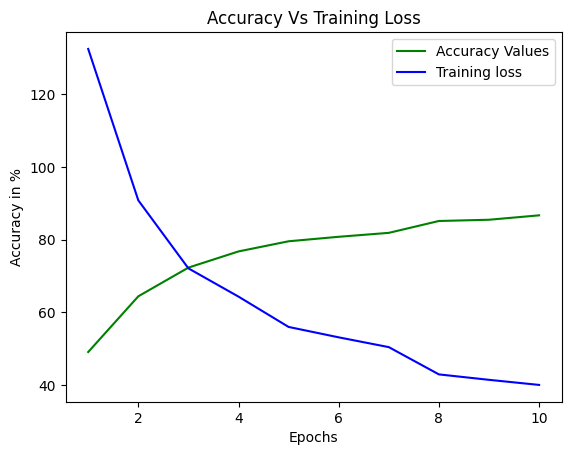

In [29]:
epochvalues = range(1,11)
acc_val = accuracyvalues[:10]
train_loss = training_loss[:10]
plt.plot(epochvalues,acc_val,'g',label='Accuracy Values')
plt.plot(epochvalues,train_loss,'b',label='Training loss')
plt.title('Accuracy Vs Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy in %')
plt.legend()
plt.show()

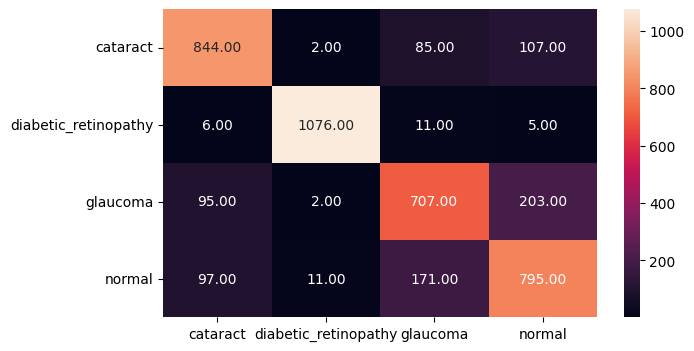

In [30]:
#Plotting Confusion Matrix
df_cm = pd.DataFrame(fold_con_matrix, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (7,4))
sn.heatmap(df_cm, annot=True,fmt='.2f')
plt.savefig('output.png')

In [33]:
import random
test_dataset_path = Path('dataset')
test_dataset_list_path = os.listdir(test_dataset_path)
test_randomdisease_path = random.choice(test_dataset_list_path)
test_random = test_dataset_path/test_randomdisease_path
test_random

PosixPath('dataset/diabetic_retinopathy')

In [36]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import random

class_mapping_values = {0: "cataract", 1: "diabetic_retinopathy", 2: "glaucoma", 3: "normal"}

def prepare_eyedisease_prediction_df():
    test_dataset_path = Path('dataset')
    test_dataset_list_path = os.listdir(test_dataset_path)
    test_randomdisease_path = random.choice(test_dataset_list_path)
    test_random = test_dataset_path/test_randomdisease_path
    test_dataframe = pd.DataFrame()

    #Appending values to the images - Key value pair
    for imagePath in tqdm(list(test_random.iterdir()), desc='cataract'):
        test_dataframe = test_dataframe.append({
            'image': str(imagePath),
            'eye_disease_type': 0
        }, ignore_index=True)

    for imagePath in tqdm(list(test_random.iterdir()), desc='diabetic_retinopathy'):
        test_dataframe = test_dataframe.append({
            'image': str(imagePath),
            'eye_disease_type': 1
        }, ignore_index=True)

    for imagePath in tqdm(list(test_random.iterdir()), desc='glaucoma'):
        test_dataframe = test_dataframe.append({
            'image': str(imagePath),
            'eye_disease_type': 2
        }, ignore_index=True)
        
    for imagePath in tqdm(list(test_random.iterdir()), desc='surgical'):
        test_dataframe = test_dataframe.append({
            'image': str(imagePath),
            'eye_disease_type': 3
        }, ignore_index=True)
        
    
    #Counts the number of images in each category
    print("Length of the Test_Dataframe",len(test_dataframe.value_counts()))
    return Eye_Class(test_dataframe)

In [39]:
import torch
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from PIL import Image

# Load the trained model
model_path = 'eye_disease_classification.pkl'
model = torch.load(model_path)

# Define the transformation pipeline
transformations = Compose([
    Resize((32, 32)),
    ToTensor(),
    Normalize((0.5667, 0.5198, 0.4955), (0.229, 0.224, 0.225))
])

def test_eyedisease_predict():
    test_dataframe = prepare_eyedisease_prediction_df()
    random_sampler = torch.utils.data.RandomSampler(test_dataframe, num_samples=32, replacement=True)
    test_loader = DataLoader(test_dataframe, batch_size=32, num_workers=0, sampler=random_sampler)
    test_data = next(iter(test_loader))
    inputs, targets = test_data['image'], test_data['eye_disease_type']
    test_output = modelTrained(inputs)

    # Print the predicted eye disease types for the test samples
    class_mapping_values = {0: "cataract", 1: "diabetic_retinopathy", 2: "glaucoma", 3: "normal"}
    for idx, pred in enumerate(test_output):
        predicted_class = torch.argmax(pred, dim=0).item()
        predicted_disease = class_mapping_values[predicted_class]
        print(f"Sample {idx+1} - Predicted Eye Disease: {predicted_disease}")

test_eyedisease_predict()


surgical: 100%|██████████| 1038/1038 [00:01<00:00, 931.36it/s]


Length of the Test_Dataframe 4152
Sample 1 - Predicted Eye Disease: cataract
Sample 2 - Predicted Eye Disease: normal
Sample 3 - Predicted Eye Disease: normal
Sample 4 - Predicted Eye Disease: cataract
Sample 5 - Predicted Eye Disease: cataract
Sample 6 - Predicted Eye Disease: cataract
Sample 7 - Predicted Eye Disease: cataract
Sample 8 - Predicted Eye Disease: cataract
Sample 9 - Predicted Eye Disease: normal
Sample 10 - Predicted Eye Disease: normal
Sample 11 - Predicted Eye Disease: glaucoma
Sample 12 - Predicted Eye Disease: cataract
Sample 13 - Predicted Eye Disease: cataract
Sample 14 - Predicted Eye Disease: cataract
Sample 15 - Predicted Eye Disease: cataract
Sample 16 - Predicted Eye Disease: cataract
Sample 17 - Predicted Eye Disease: cataract
Sample 18 - Predicted Eye Disease: cataract
Sample 19 - Predicted Eye Disease: cataract
Sample 20 - Predicted Eye Disease: cataract
Sample 21 - Predicted Eye Disease: cataract
Sample 22 - Predicted Eye Disease: cataract
Sample 23 - Pre